In [1]:
import os
import shutil
import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report
from tensorflow.keras.models import Model,load_model

In [51]:
diagnosis_df = pd.read_csv('C:/Users/Swapnil D/OneDrive/Desktop/LLD New/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head()

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [52]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Asthma             9
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Name: count, dtype: int64

disease
COPD              47.761194
Healthy           19.402985
URTI              10.447761
Asthma             6.716418
Bronchiectasis     5.223881
Pneumonia          4.477612
Bronchiolitis      4.477612
LRTI               1.492537
Name: proportion, dtype: float64


(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

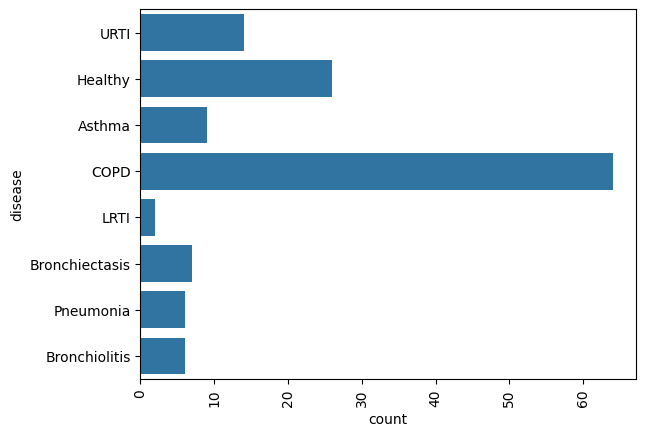

In [53]:
sns.countplot(diagnosis_df.disease)
plt.xticks(rotation=90)

In [54]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data_stretched = librosa.effects.time_stretch(data, rate=rate)
    return data_stretched


def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [55]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

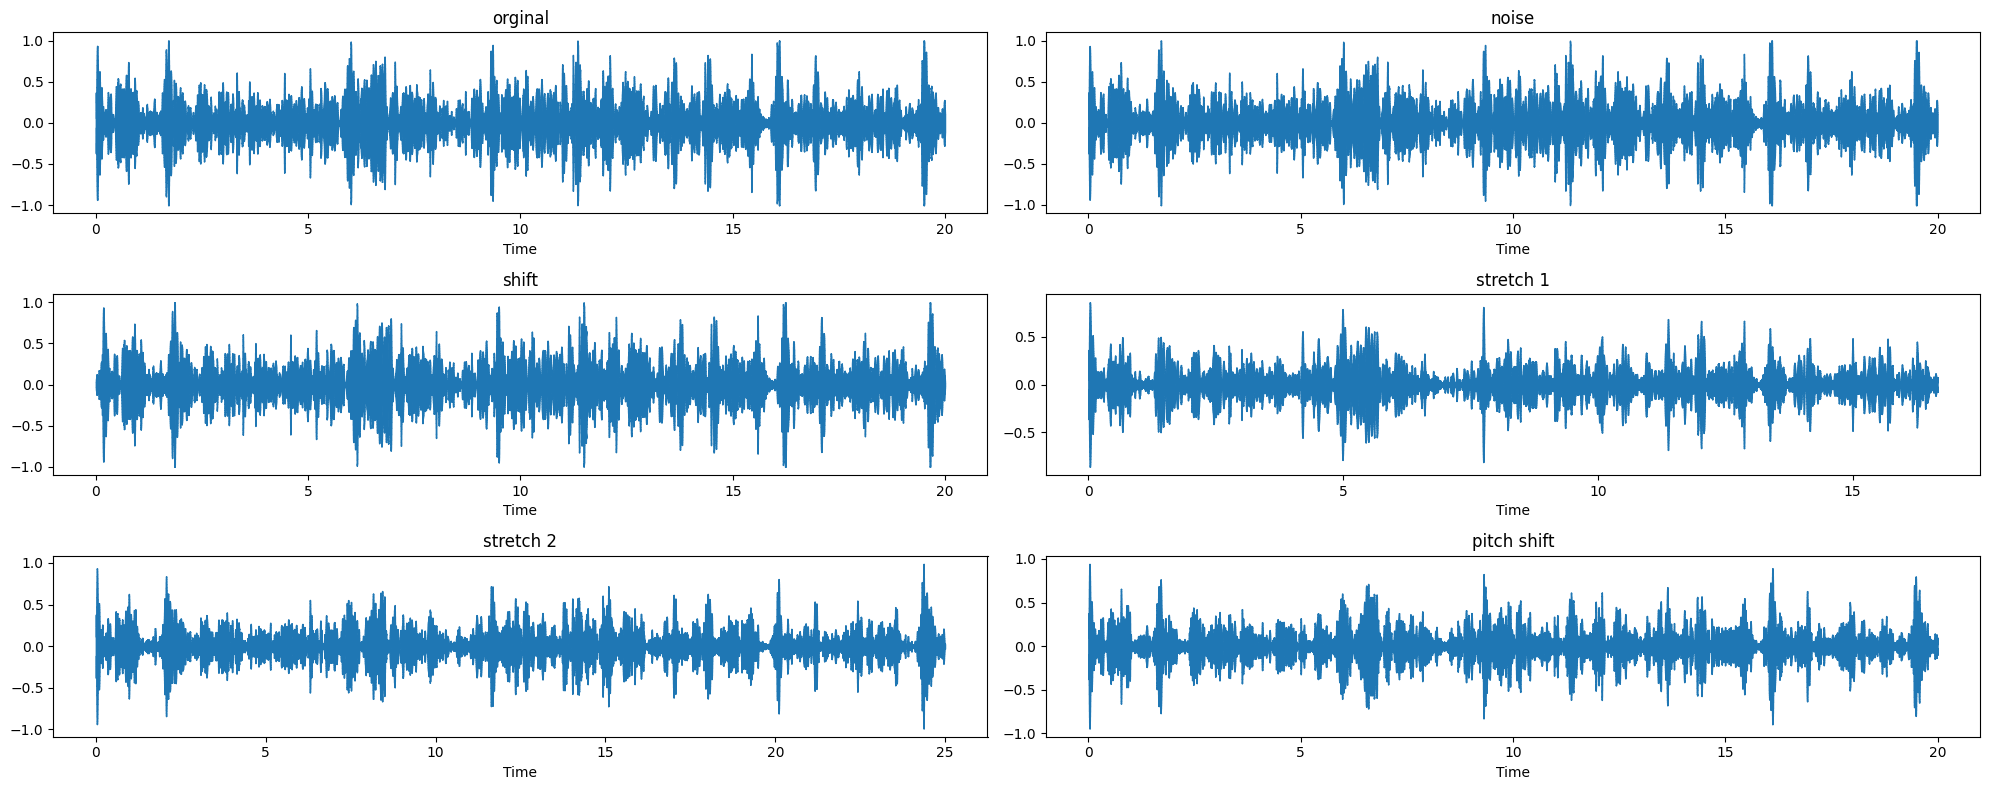

In [56]:
show_audio('C:/Users/Swapnil D/OneDrive/Desktop/LLD New/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_files/103_2b2_Ar_mc_LittC2SE.wav')

In [57]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')



    plt.tight_layout()

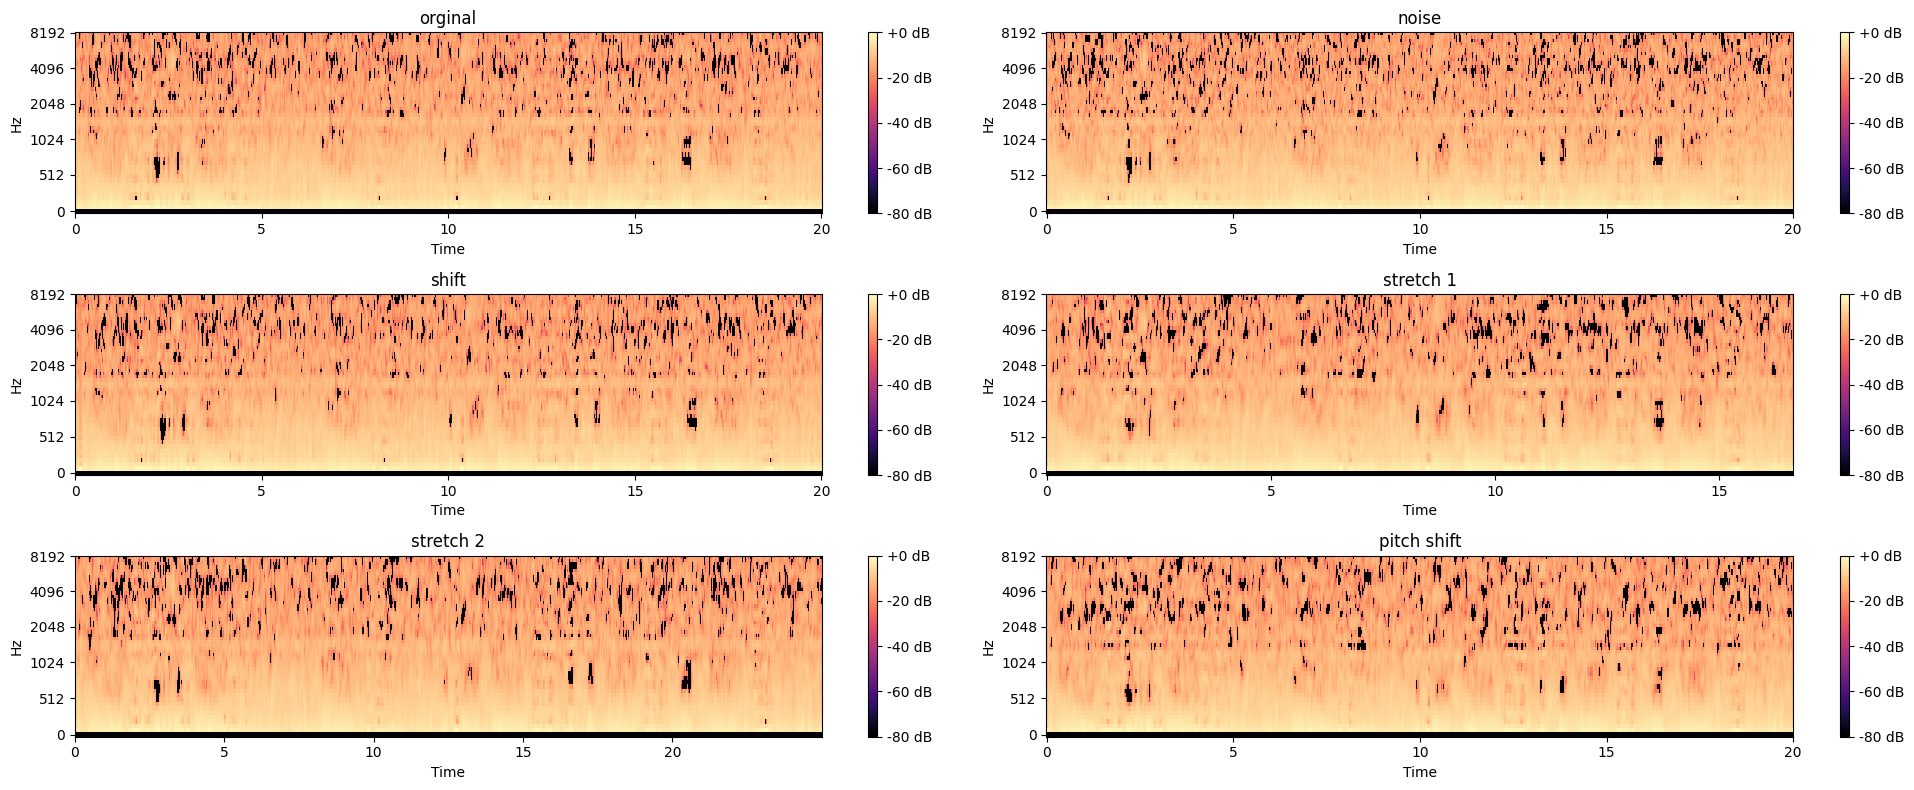

In [58]:
show_audio_features('C:/Users/Swapnil D/OneDrive/Desktop/LLD New/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_files/103_2b2_Ar_mc_LittC2SE.wav')

In [59]:
def mfccs_feature_exteraction(dir_):
    
    X_=[]
    y_=[]

    COPD=[]
    copd_count=0

    data = diagnosis_df
    features = 52

    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                else:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)



    X_data = np.array(X_)
    y_data = np.array(y_)


    return X_data, y_data

In [60]:
# Define the source and destination directories for the duplicated data
original_data_dir = 'C:/Users/Swapnil D/OneDrive/Desktop/LLD New/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_files/'
duplicated_data_dir = 'C:/Users/Swapnil D/OneDrive/Desktop/LLD New/dupilcates/'

In [61]:
# Create the duplicated data directory if it doesn't exist
os.makedirs(duplicated_data_dir, exist_ok=True)

# Duplicate the audio files from the original directory to the duplicated directory
for filename in os.listdir(original_data_dir):
    # Construct the full path for the original and duplicated files
    original_file_path = os.path.join(original_data_dir, filename)
    duplicated_file_path = os.path.join(duplicated_data_dir, filename)

    # Copy the file to the duplicated directory
    shutil.copyfile(original_file_path, duplicated_file_path)

In [62]:
x_mfccs, y = mfccs_feature_exteraction(duplicated_data_dir)

In [63]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','aqua','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

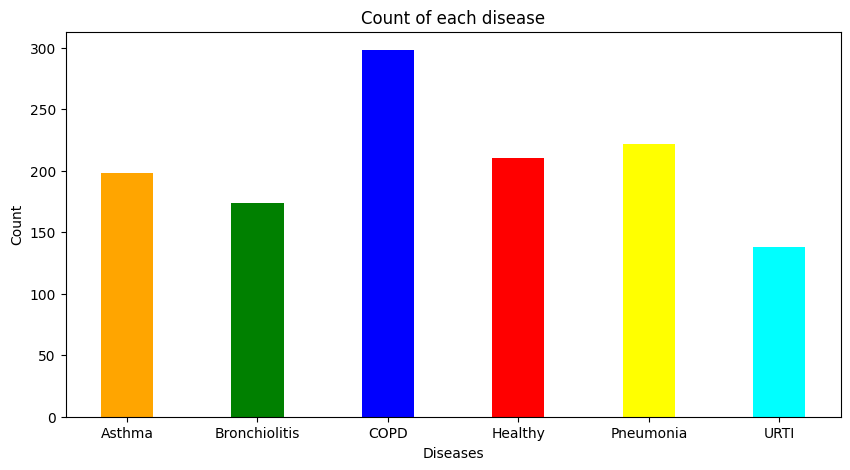

{np.str_('Asthma'): np.int64(198), np.str_('Bronchiolitis'): np.int64(174), np.str_('COPD'): np.int64(298), np.str_('Healthy'): np.int64(210), np.str_('Pneumonia'): np.int64(222), np.str_('URTI'): np.int64(138)}


In [64]:
augmented_lables_count(y)

In [65]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import librosa
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# ======================
# 1. Configuration
# ======================
AUDIO_DIR = 'C:/Users/Swapnil D/OneDrive/Desktop/LLD New/dupilcates/'
DIAGNOSIS_CSV = 'C:/Users/Swapnil D/OneDrive/Desktop/LLD New/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
CLASSES = ["COPD", "Bronchiolitis", "Pneumonia", "URTI", "Healthy","Asthma"]
N_MFCC = 128
MAX_TIMESTEPS = 500  # 5 seconds at 100Hz MFCC resolution

# ======================
# 2. Data Preparation
# ======================
def load_data():
    """Load and validate audio files with labels"""
    diagnosis_df = pd.read_csv(DIAGNOSIS_CSV, names=['patient_id', 'disease'])
    
    file_paths = []
    labels = []
    
    for fname in os.listdir(AUDIO_DIR):
        if not fname.endswith('.wav'):
            continue
            
        try:
            patient_id = int(fname[:3])
            if patient_id in [108, 115]:
                continue
                
            diagnosis = diagnosis_df[diagnosis_df['patient_id'] == patient_id]['disease'].values[0]
            
            # Merge similar classes
            if diagnosis in ['Bronchiectasis', 'Bronchiolitis']:
                diagnosis = 'Bronchiolitis'
                
            if diagnosis not in CLASSES:
                continue
                
            file_paths.append(os.path.join(AUDIO_DIR, fname))
            labels.append(CLASSES.index(diagnosis))
            
        except Exception as e:
            print(f"Skipping {fname}: {str(e)}")
    
    return np.array(file_paths), np.array(labels)

# ======================
# 3. Feature Extraction
# ======================
def extract_features(file_path):
    """Extract and format MFCC features"""
    y, sr = librosa.load(file_path, sr=None)
    
    # Standard MFCC extraction
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    
    # Maintain temporal dimension
    if mfcc.shape[1] < MAX_TIMESTEPS:
        mfcc = np.pad(mfcc, ((0, 0), (0, MAX_TIMESTEPS - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_TIMESTEPS]
    
    return mfcc.T  # (timesteps, features)

# ======================
# 4. Data Pipeline
# ======================
def create_datasets(file_paths, labels):
    """Create balanced, stratified datasets"""
    # Extract features
    features = np.array([extract_features(fp) for fp in file_paths])
    
    # Handle class imbalance
    features_flat = features.reshape(len(features), -1)
    smote = SMOTE()
    features_balanced, labels_balanced = smote.fit_resample(features_flat, labels)
    features_balanced = features_balanced.reshape(-1, MAX_TIMESTEPS, N_MFCC)
    
    # Split datasets
    X_train, X_test, y_train, y_test = train_test_split(
        features_balanced, labels_balanced, 
        test_size=0.15, 
        stratify=labels_balanced,
        random_state=10
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, 
        test_size=0.15, 
        stratify=y_train,
        random_state=10
    )
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(1000).batch(32).prefetch(2)
    
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(2)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(2)
    
    return train_ds, val_ds, test_ds

# ======================
# 5. Model Architecture
# ======================
def create_model():
    """Build optimized audio classification model"""
    inputs = layers.Input(shape=(MAX_TIMESTEPS, N_MFCC))
    
    # Input normalization
    x = layers.LayerNormalization()(inputs)
    
    # Temporal processing
    x = layers.Conv1D(256, 11, activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    # Contextual understanding
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.GlobalAvgPool1D()(x)
    
    # Classification head
    x = layers.Dense(512, activation='swish')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ======================
# 6. Training Execution
# ======================
def train_model():
    """Full training pipeline"""
    # Load data
    file_paths, labels = load_data()
    
    # Compute class weights
    classes = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    class_weight_dict = {int(cls): weight for cls, weight in zip(classes, class_weights)}
    
    # Create datasets
    train_ds, val_ds, test_ds = create_datasets(file_paths, labels)
    
    # Build model
    model = create_model()
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True),
        ModelCheckpoint("lung_sound_new.h5", save_best_only=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    ]
    
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    
    # Evaluate
    model.load_weights("lung_sound_new.h5")
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"\nTest Accuracy: {test_acc:.2%}")
    
    # Generate reports
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds).argmax(axis=1)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    return model

# ======================
# 7. Prediction Pipeline
# ======================
class LungSoundClassifier:
    """Production-ready classifier"""
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)
        self.classes = CLASSES
        self.n_mfcc = N_MFCC
        self.max_timesteps = MAX_TIMESTEPS
        
    def predict(self, audio_path):
        """Predict class from audio file"""
        processed = self._preprocess(audio_path)
        pred = self.model.predict(processed)
        return self.classes[np.argmax(pred)]
    
    def _preprocess(self, audio_path):
        """Match training preprocessing exactly"""
        y, sr = librosa.load(audio_path, sr=None)
        
        # Standard MFCC extraction
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        
        # Maintain temporal structure
        if mfcc.shape[1] < self.max_timesteps:
            mfcc = np.pad(mfcc, ((0, 0), (0, self.max_timesteps - mfcc.shape[1])))
        else:
            mfcc = mfcc[:, :self.max_timesteps]
            
        return mfcc.T[np.newaxis, ...]  # Add batch dimension

# ======================
# 8. Main Execution
# ======================
if __name__ == "__main__":
    # Train and save model
    trained_model = train_model()
    
    # Example usage
    classifier = LungSoundClassifier("lung_sound_new.h5")
    prediction = classifier.predict("C:/Users/Swapnil D/OneDrive/Desktop/AUdio/BP106_Asthma,E W,P L U,45,F.wav")
    print(f"\nPrediction Result: {prediction}")

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6399 - loss: 3.2974

108/108 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6408 - loss: 3.2892 - val_accuracy: 0.6870 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8699 - loss: 1.1618

108/108 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8699 - loss: 1.1603 - val_accuracy: 0.6936 - val_loss: 0.8104 - learning_rate: 0.0010
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9161 - loss: 0.5460 - val_accuracy: 0.7133 - val_loss: 0.8586 - learning_rate: 0.0010
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9412 - loss: 0.3185

108/108 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9412 - loss: 0.3181 - val_accuracy: 0.8962 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9517 - loss: 0.1775

108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9517 - loss: 0.1773 - val_accuracy: 0.9193 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9524 - loss: 0.1956 - val_accuracy: 0.7117 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9519 - loss: 0.2262 - val_accuracy: 0.8863 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9618 - loss: 0.1424

108/108 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9618 - loss: 0.1422 - val_accuracy: 0.9572 - val_loss: 0.2278 - learning_rate: 0.0010
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9648 - loss: 0.0632 - val_accuracy: 0.8913 - val_loss: 0.3875 - learning_rate: 0.0010
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9706 - loss: 0.0668

108/108 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9705 - loss: 0.0671 - val_accuracy: 0.9423 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9603 - loss: 0.0689 - val_accuracy: 0.9473 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 12/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9656 - loss: 0.1391 - val_accuracy: 0.9506 - val_loss: 0.2548 - learning_rate: 0.0010
Epoch 13/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9671 - loss: 0.0798

108/108 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9671 - loss: 0.0797 - val_accuracy: 0.9605 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 14/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9720 - loss: 0.0424

108/108 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9720 - loss: 0.0424 - val_accuracy: 0.9605 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 15/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9725 - loss: 0.0562 - val_accuracy: 0.9605 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 16/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9714 - loss: 0.0673 - val_accuracy: 0.9555 - val_loss: 0.1909 - learning_rate: 0.0010
Epoch 17/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9700 - loss: 0.0548 - val_accuracy: 0.9555 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 18/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9761 - loss: 0.0392 - val_accuracy: 0.8122 - val_loss: 0.7592 - learning_rate: 0.0010
Epoch 19/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9810 - loss: 0.0323

108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9809 - loss: 0.0323 - val_accuracy: 0.9638 - val_loss: 0.1339 - learning_rate: 0.0010
Epoch 20/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9812 - loss: 0.0439 - val_accuracy: 0.9588 - val_loss: 0.1667 - learning_rate: 0.0010
Epoch 21/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9814 - loss: 0.0211 - val_accuracy: 0.9143 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 22/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9818 - loss: 0.0480 - val_accuracy: 0.9638 - val_loss: 0.1695 - learning_rate: 0.0010
Epoch 23/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9820 - loss: 0.0185

108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9820 - loss: 0.0185 - val_accuracy: 0.9720 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 24/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9841 - loss: 0.0181

108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9840 - loss: 0.0181 - val_accuracy: 0.9753 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 25/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9807 - loss: 0.0278 - val_accuracy: 0.9539 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 26/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9843 - loss: 0.0300 - val_accuracy: 0.9703 - val_loss: 0.1282 - learning_rate: 0.0010
Epoch 27/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9892 - loss: 0.0114 - val_accuracy: 0.9753 - val_loss: 0.1142 - learning_rate: 0.0010
Epoch 28/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9890 - loss: 0.0112 - val_accuracy: 0.8040 - val_loss: 1.2704 - learning_rate: 0.0010
Epoch 29/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9842 - loss: 0.0743
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9842 - loss: 0.074

108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9869 - loss: 0.0266 - val_accuracy: 0.9802 - val_loss: 0.0823 - learning_rate: 5.0000e-04
Epoch 31/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9905 - loss: 0.0085

108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9905 - loss: 0.0085 - val_accuracy: 0.9819 - val_loss: 0.0670 - learning_rate: 5.0000e-04
Epoch 32/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9931 - loss: 0.0068 - val_accuracy: 0.9819 - val_loss: 0.0684 - learning_rate: 5.0000e-04
Epoch 33/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9939 - loss: 0.0057 - val_accuracy: 0.9835 - val_loss: 0.0817 - learning_rate: 5.0000e-04
Epoch 34/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9927 - loss: 0.0075 - val_accuracy: 0.9769 - val_loss: 0.1235 - learning_rate: 5.0000e-04
Epoch 35/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9943 - loss: 0.0081 - val_accuracy: 0.8847 - val_loss: 0.4990 - learning_rate: 5.0000e-04
Epoch 36/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9885 - loss: 0.0259
Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 

108/108 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9939 - loss: 0.0074 - val_accuracy: 0.9868 - val_loss: 0.0583 - learning_rate: 2.5000e-04
Epoch 41/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9947 - loss: 0.0043 - val_accuracy: 0.9868 - val_loss: 0.0628 - learning_rate: 2.5000e-04
Epoch 42/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9958 - loss: 0.0054 - val_accuracy: 0.9868 - val_loss: 0.0747 - learning_rate: 2.5000e-04
Epoch 43/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9947 - loss: 0.0051 - val_accuracy: 0.9868 - val_loss: 0.0607 - learning_rate: 2.5000e-04
Epoch 44/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9975 - loss: 0.0039

108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9975 - loss: 0.0039 - val_accuracy: 0.9868 - val_loss: 0.0568 - learning_rate: 2.5000e-04
Epoch 45/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9954 - loss: 0.0048

108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9954 - loss: 0.0048 - val_accuracy: 0.9868 - val_loss: 0.0558 - learning_rate: 2.5000e-04
Epoch 46/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9978 - loss: 0.0039

108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9978 - loss: 0.0039 - val_accuracy: 0.9868 - val_loss: 0.0502 - learning_rate: 2.5000e-04
Epoch 47/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9966 - loss: 0.0043 - val_accuracy: 0.9868 - val_loss: 0.0618 - learning_rate: 2.5000e-04
Epoch 48/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9961 - loss: 0.0041 - val_accuracy: 0.9868 - val_loss: 0.0738 - learning_rate: 2.5000e-04
Epoch 49/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9975 - loss: 0.0027 - val_accuracy: 0.9868 - val_loss: 0.0817 - learning_rate: 2.5000e-04
Epoch 50/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9964 - loss: 0.0028 - val_accuracy: 0.9868 - val_loss: 0.0728 - learning_rate: 2.5000e-04
Epoch 51/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9959 - loss: 0.0038
Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
108/108 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step

Prediction Result: Asthma


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.9933 - loss: 0.0286

Overall Test Accuracy: 99.16%
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 405ms/step


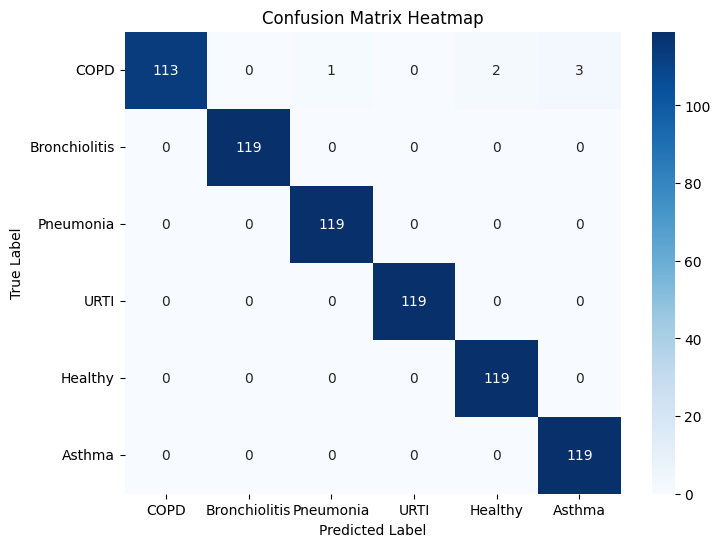

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step

Predicted Disease: Asthma


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot heatmap for the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Reload the test dataset without retraining
file_paths, labels = load_data()
_, _, test_ds = create_datasets(file_paths, labels)  # Only get test_ds

# Load trained model
trained_model = tf.keras.models.load_model("lung_sound_new.h5")

# Evaluate model on test dataset
test_loss, test_acc = trained_model.evaluate(test_ds)
print(f"\nOverall Test Accuracy: {test_acc:.2%}")

# Extract true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Get model predictions
y_pred = trained_model.predict(test_ds).argmax(axis=1)

# Plot heatmap
plot_confusion_matrix(y_true, y_pred, CLASSES)

# ========== PREDICT A SINGLE AUDIO FILE ==========
classifier = LungSoundClassifier("lung_sound_new.h5")
prediction = classifier.predict("C:/Users/Swapnil D/OneDrive/Desktop/AUdio/BP10_Asthma,E W,P R U,59,M.wav")
print(f"\nPredicted Disease: {prediction}")


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import librosa
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# ======================
# 1. Configuration
# ======================
AUDIO_DIR = 'C:/Users/Swapnil D/OneDrive/Desktop/LLD New/dupilcates/'
DIAGNOSIS_CSV = 'C:/Users/Swapnil D/OneDrive/Desktop/LLD New/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
CLASSES = ["COPD", "Bronchiolitis", "Pneumonia", "URTI", "Healthy","Asthma"]
N_MFCC = 128
MAX_TIMESTEPS = 500

# ======================
# 2. Data Preparation
# ======================
def load_data():
    diagnosis_df = pd.read_csv(DIAGNOSIS_CSV, names=['patient_id', 'disease'])
    file_paths, labels = [], []
    
    for fname in os.listdir(AUDIO_DIR):
        if not fname.endswith('.wav'):
            continue
        try:
            patient_id = int(fname[:3])
            if patient_id in [108, 115]:
                continue
            diagnosis = diagnosis_df[diagnosis_df['patient_id'] == patient_id]['disease'].values[0]
            if diagnosis in ['Bronchiectasis', 'Bronchiolitis']:
                diagnosis = 'Bronchiolitis'
            if diagnosis not in CLASSES:
                continue
            file_paths.append(os.path.join(AUDIO_DIR, fname))
            labels.append(CLASSES.index(diagnosis))
        except Exception as e:
            print(f"Skipping {fname}: {str(e)}")
    return np.array(file_paths), np.array(labels)

# ======================
# 3. Feature Extraction
# ======================
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    if mfcc.shape[1] < MAX_TIMESTEPS:
        mfcc = np.pad(mfcc, ((0, 0), (0, MAX_TIMESTEPS - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_TIMESTEPS]
    return mfcc.T

# ======================
# 4. Data Pipeline
# ======================
def create_datasets(file_paths, labels):
    features = np.array([extract_features(fp) for fp in file_paths])
    features_flat = features.reshape(len(features), -1)
    smote = SMOTE()
    features_balanced, labels_balanced = smote.fit_resample(features_flat, labels)
    features_balanced = features_balanced.reshape(-1, MAX_TIMESTEPS, N_MFCC)
    
    X_train, X_test, y_train, y_test = train_test_split(features_balanced, labels_balanced, test_size=0.15, stratify=labels_balanced, random_state=10)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=10)
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(32).prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(2)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(2)
    
    return train_ds, val_ds, test_ds

# ======================
# 5. Model Architecture (CNN-BiGRU)
# ======================
def create_model():
    inputs = layers.Input(shape=(MAX_TIMESTEPS, N_MFCC))
    x = layers.LayerNormalization()(inputs)
    x = layers.Conv1D(256, 11, activation='swish', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True))(x)
    x = layers.GlobalAvgPool1D()(x)
    x = layers.Dense(512, activation='swish')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ======================
# 6. Training Execution
# ======================
def train_model():
    file_paths, labels = load_data()
    classes = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    class_weight_dict = {int(cls): weight for cls, weight in zip(classes, class_weights)}
    train_ds, val_ds, test_ds = create_datasets(file_paths, labels)
    model = create_model()
    callbacks = [EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True), ModelCheckpoint("lung_sound_model_bigru.h5", save_best_only=True), ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)]
    model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks, class_weight=class_weight_dict)
    model.load_weights("lung_sound_model_bigru.h5")
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"\nTest Accuracy: {test_acc:.2%}")
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds).argmax(axis=1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    return model

# ======================
# 7. Prediction Pipeline
# ======================
class LungSoundClassifier:
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)
        self.classes = CLASSES
    def predict(self, audio_path):
        processed = extract_features(audio_path)[np.newaxis, ...]
        pred = self.model.predict(processed)
        return self.classes[np.argmax(pred)]

# ======================
# 8. Main Execution
# ======================
if __name__ == "__main__":
    trained_model = train_model()
    classifier = LungSoundClassifier("lung_sound_model_bigru.h5")
    prediction = classifier.predict("C:/Users/Swapnil D/OneDrive/Desktop/RES/Bronchiolitis2.wav")
    print(f"\nPrediction Result: {prediction}")


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5976 - loss: 3.6152

108/108 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5986 - loss: 3.6056 - val_accuracy: 0.6293 - val_loss: 1.0198 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8608 - loss: 1.1366

108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8609 - loss: 1.1356 - val_accuracy: 0.7727 - val_loss: 0.6690 - learning_rate: 0.0010
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8811 - loss: 0.8360

108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8811 - loss: 0.8354 - val_accuracy: 0.8666 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9185 - loss: 0.4735 - val_accuracy: 0.7364 - val_loss: 1.4270 - learning_rate: 0.0010
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9266 - loss: 0.3835

108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9266 - loss: 0.3835 - val_accuracy: 0.9275 - val_loss: 0.3698 - learning_rate: 0.0010
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9389 - loss: 0.2221 - val_accuracy: 0.8105 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9514 - loss: 0.1735 - val_accuracy: 0.8418 - val_loss: 0.6482 - learning_rate: 0.0010
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9570 - loss: 0.1248

108/108 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9569 - loss: 0.1248 - val_accuracy: 0.9357 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9613 - loss: 0.0878 - val_accuracy: 0.8649 - val_loss: 0.6314 - learning_rate: 0.0010
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9557 - loss: 0.0939 - val_accuracy: 0.7776 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9575 - loss: 0.1159

108/108 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9575 - loss: 0.1157 - val_accuracy: 0.9539 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 12/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9607 - loss: 0.0565 - val_accuracy: 0.7545 - val_loss: 1.6530 - learning_rate: 0.0010
Epoch 13/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9625 - loss: 0.1421 - val_accuracy: 0.9077 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 14/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9707 - loss: 0.0439

108/108 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9706 - loss: 0.0440 - val_accuracy: 0.9572 - val_loss: 0.2032 - learning_rate: 0.0010
Epoch 15/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9739 - loss: 0.0428

108/108 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9738 - loss: 0.0429 - val_accuracy: 0.9555 - val_loss: 0.2007 - learning_rate: 0.0010
Epoch 16/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9719 - loss: 0.0356

108/108 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9719 - loss: 0.0356 - val_accuracy: 0.9588 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 17/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9733 - loss: 0.0352 - val_accuracy: 0.9094 - val_loss: 0.4125 - learning_rate: 0.0010
Epoch 18/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9739 - loss: 0.0328

108/108 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9739 - loss: 0.0329 - val_accuracy: 0.9605 - val_loss: 0.1764 - learning_rate: 0.0010
Epoch 19/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9772 - loss: 0.0324

108/108 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9772 - loss: 0.0324 - val_accuracy: 0.9638 - val_loss: 0.1699 - learning_rate: 0.0010
Epoch 20/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9771 - loss: 0.0403 - val_accuracy: 0.9621 - val_loss: 0.1803 - learning_rate: 0.0010
Epoch 21/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9720 - loss: 0.0449 - val_accuracy: 0.7545 - val_loss: 1.7755 - learning_rate: 0.0010
Epoch 22/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9657 - loss: 0.2319

108/108 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9657 - loss: 0.2311 - val_accuracy: 0.9605 - val_loss: 0.1658 - learning_rate: 0.0010
Epoch 23/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9728 - loss: 0.0380

108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9728 - loss: 0.0381 - val_accuracy: 0.9605 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 24/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9750 - loss: 0.0313 - val_accuracy: 0.9621 - val_loss: 0.1611 - learning_rate: 0.0010
Epoch 25/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9771 - loss: 0.0265 - val_accuracy: 0.9621 - val_loss: 0.1618 - learning_rate: 0.0010
Epoch 26/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9778 - loss: 0.0208

108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9778 - loss: 0.0208 - val_accuracy: 0.9687 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 27/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9784 - loss: 0.0211 - val_accuracy: 0.9671 - val_loss: 0.1284 - learning_rate: 0.0010
Epoch 28/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9804 - loss: 0.0183

108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9804 - loss: 0.0183 - val_accuracy: 0.9703 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 29/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9866 - loss: 0.0147 - val_accuracy: 0.9654 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 30/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9819 - loss: 0.0175 - val_accuracy: 0.9654 - val_loss: 0.1369 - learning_rate: 0.0010
Epoch 31/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9858 - loss: 0.0198

108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9858 - loss: 0.0198 - val_accuracy: 0.9736 - val_loss: 0.1036 - learning_rate: 0.0010
Epoch 32/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9857 - loss: 0.0146 - val_accuracy: 0.9703 - val_loss: 0.1292 - learning_rate: 0.0010
Epoch 33/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9874 - loss: 0.0115 - val_accuracy: 0.9736 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 34/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9844 - loss: 0.0433

108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9844 - loss: 0.0433 - val_accuracy: 0.9786 - val_loss: 0.1002 - learning_rate: 0.0010
Epoch 35/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9889 - loss: 0.0142

108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9889 - loss: 0.0142 - val_accuracy: 0.9786 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 36/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9874 - loss: 0.0109 - val_accuracy: 0.9292 - val_loss: 0.2946 - learning_rate: 0.0010
Epoch 37/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9881 - loss: 0.0215 - val_accuracy: 0.9687 - val_loss: 0.1271 - learning_rate: 0.0010
Epoch 38/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9890 - loss: 0.0136 - val_accuracy: 0.9769 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 39/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9929 - loss: 0.0079 - val_accuracy: 0.9819 - val_loss: 0.0835 - learning_rate: 0.0010
Epoch 40/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9906 - loss: 0.0090

108/108 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9906 - loss: 0.0090 - val_accuracy: 0.9885 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 41/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9911 - loss: 0.0109 - val_accuracy: 0.9819 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 42/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9926 - loss: 0.0077 - val_accuracy: 0.9835 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 43/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9949 - loss: 0.0080 - val_accuracy: 0.9621 - val_loss: 0.1398 - learning_rate: 0.0010
Epoch 44/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9946 - loss: 0.0053 - val_accuracy: 0.9769 - val_loss: 0.1312 - learning_rate: 0.0010
Epoch 45/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9951 - loss: 0.0058
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
108/108 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9951 - loss: 0.005

108/108 ━━━━━━━━━━━━━━━━━━━━ 104s 959ms/step - accuracy: 0.9973 - loss: 0.0018 - val_accuracy: 0.9901 - val_loss: 0.0478 - learning_rate: 1.2500e-04
Epoch 57/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 104s 963ms/step - accuracy: 0.9979 - loss: 0.0021 - val_accuracy: 0.9835 - val_loss: 0.0703 - learning_rate: 1.2500e-04
Epoch 58/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 104s 963ms/step - accuracy: 0.9958 - loss: 0.0023 - val_accuracy: 0.9802 - val_loss: 0.1150 - learning_rate: 1.2500e-04
Epoch 59/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 105s 971ms/step - accuracy: 0.9979 - loss: 0.0019 - val_accuracy: 0.9835 - val_loss: 0.0692 - learning_rate: 1.2500e-04
Epoch 60/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 105s 972ms/step - accuracy: 0.9971 - loss: 0.0025 - val_accuracy: 0.9819 - val_loss: 0.0931 - learning_rate: 1.2500e-04
Epoch 61/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9984 - loss: 0.0027
Epoch 61: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
108/108 ━━━━━━━━━━━━━━━━━━━━ 104s 967

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step

Prediction Result: Bronchiolitis


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.9949 - loss: 0.0108

Overall Test Accuracy: 99.44%
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step


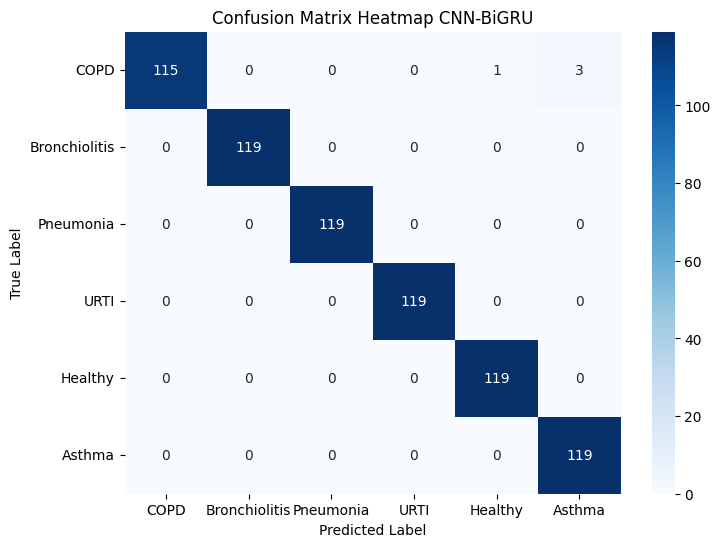

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step

Predicted Disease: Asthma


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot heatmap for the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap CNN-BiGRU')
    plt.show()

# Reload the test dataset without retraining
file_paths, labels = load_data()
_, _, test_ds = create_datasets(file_paths, labels)  # Only get test_ds

# Load trained model
trained_model = tf.keras.models.load_model("lung_sound_model_bigru.h5")

# Evaluate model on test dataset
test_loss, test_acc = trained_model.evaluate(test_ds)
print(f"\nOverall Test Accuracy: {test_acc:.2%}")

# Extract true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Get model predictions
y_pred = trained_model.predict(test_ds).argmax(axis=1)

# Plot heatmap
plot_confusion_matrix(y_true, y_pred, CLASSES)

# ========== PREDICT A SINGLE AUDIO FILE ==========
classifier = LungSoundClassifier("lung_sound_model_bigru.h5")
prediction = classifier.predict("C:/Users/Swapnil D/OneDrive/Desktop/AUdio/DP91_asthma,E W,P R U,43,F.wav")
print(f"\nPredicted Disease: {prediction}")
